# Fake And Read News Classification

The purpose of this project is to predict whether a news is fake or true from the provided news in the dataset.

The dataset has 23,481 fake news and 21,417 true news. Each of the news has the columns or features `title`, `text`, `subject` and `date`.

Data Source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

## Summary

The custom columns `label` and `combined` are added. As of the column `label`, the value `0` is for `fake news` and the value `1` is for `true news`. As of the column `combined`, `title` and `text` are merged. We used `label` and `combined` for training models. After EDA and data cleansing, we created a CNN model and a multi-channel CNN model in this project.

**the validation accuracy**
- the CNN model: around 92%
- the multi-channel CNN model: around 92%

Both of the CNN model and the multi-channel CNN model are as good: the CNN model (the simpler one) is selected for our final model.

# Table of Contents

1. Importing Libraries and Dataset
1. Exploring Data
1. Cleansing Data
1. Analyzing Data
1. Preprocessing Data
1. Training Models
1. Discussion

# 1. Importing Libraries and Dataset

## Importing Libraries

First, we will import the libraries to be used in this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.callbacks import *
from keras.layers import *
from keras.models import Sequential, Model
import keras_tuner as kt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
import re

import warnings
warnings.filterwarnings('ignore')

## Importing the Data

Second, we will import tha train dataset.

In [2]:
fake_data = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true_data = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

Showing the 10 rows in the dataset.

In [3]:
fake_data.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [4]:
true_data.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


Showing the brief summary of the dataset.

In [5]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
true_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


## Adding Labels and Extracting Columns

Now we will add a label column (`0` for `fake`, `1` for `true`) and extract the columns used for creating models.

In [7]:
fake_data['label'] = 0
true_data['label'] = 1

fake_data['combined'] = fake_data['title'] + ' ' + fake_data['text']
true_data['combined'] = true_data['title'] + ' ' + fake_data['text']

In [8]:
data = pd.concat([fake_data, true_data], axis=0)
data = data[['combined','label']]

data.head()

,combined,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


# 2. Exploring Data

## Showing the Number of Fake and True News

The number of fake news is 2,000 more than that of true ones. But this is not a large problem because the number of news in both of the categories is large enough.

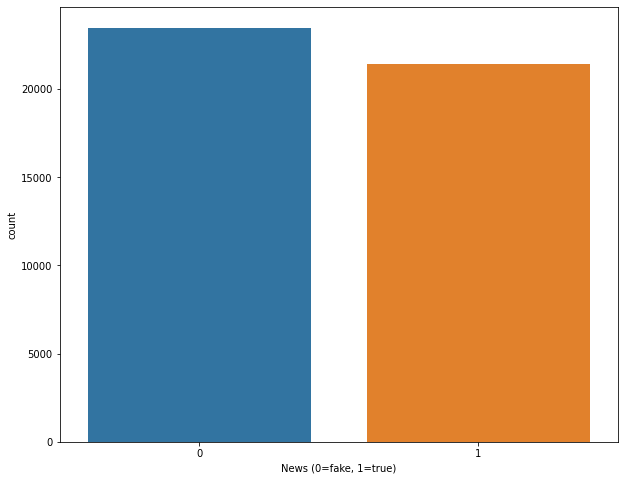

In [9]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='label', data=data)

ax.set(xlabel='News (0=fake, 1=true)')
plt.show()

## Showing the Length of News

We will show the length of news in both of the categories.

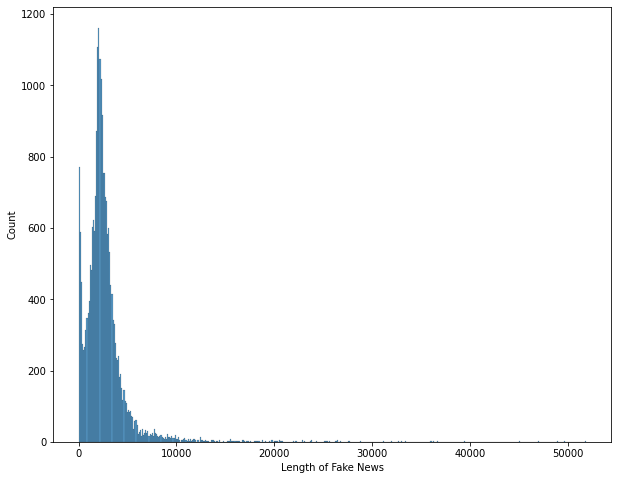

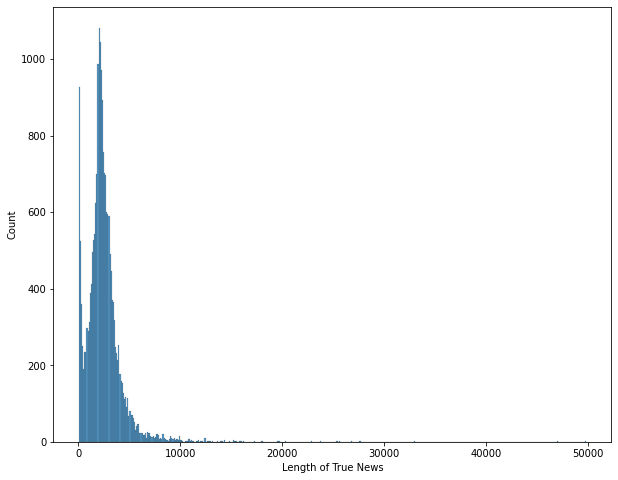

In [10]:
len_of_fake_news = data[data['label']==0]['combined'].map(lambda x : len(x))
len_of_true_news = data[data['label']==1]['combined'].map(lambda x : len(x))

len_data = {
    'len_of_fake_news': len_of_fake_news,
    'len_of_true_news': len_of_true_news
}

# non_disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_data, x='len_of_fake_news')
ax.set(xlabel='Length of Fake News')
plt.show()
# disaster
plt.figure(figsize=(10,8))
ax = sns.histplot(data=len_data, x='len_of_true_news')
ax.set(xlabel='Length of True News')
plt.show()

From the plot, we can say this:
- the length of the fake news looks longer than the true news on avarage because it has larger volume above 5,000.

## Comparing the Mean and Median

We will compare the mean and median in the length of news.

In [11]:
print('the length of fake news. mean={}, median={}'.format(np.mean(len_of_fake_news), np.median(len_of_fake_news)))
print('the length of true news. mean={}, median={}'.format(np.mean(len_of_true_news), np.median(len_of_true_news)))

the length of fake news. mean=2642.5942677058047, median=2259.0
the length of true news. mean=2447.173366951487, median=2232.0


We can say from the result:
- the length of fake news is longer than that of true news in mean

# 3. Cleansing Data

In this section, we will apply the cleansing methods below:

- removing url
- removing html tags
- removing digits
- removing punctuations
- lowering all letters
- removing stopwords
- lemmatizing
- removing 1 length words

If we remove 'noisy' words and symbols here, the models created on the cleansed data is better performed than not.

In [12]:
def preprocess_data(text):
    # removing url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text)
    
    # removing html tags
    text = re.sub(r'<.*?>',' ',text)
    
    # removing degits
    text = re.sub(r'[0-9]', '', text)
    
    # removeing mentions
    text = re.sub('@\S+', '', text)
    
    # removing punctuations (see: https://stackoverflow.com/a/37221663)
    table = str.maketrans(dict.fromkeys(string.punctuation))
    text = text.translate(table) 
    
    # lowering all letters
    text = text.lower()
    text = text.split()
    
    # removing stopwords and lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(words) for words in text if words not in stopwords.words('english')]
    
    # removing 1 length words
    text = [i for i in text if len(i)>=2] 
    text = ' '.join(text)
    return text

# apply cleansing
data['cleansed'] = data['combined'].apply(preprocess_data)

Showing the cleansed data.

In [13]:
data.head(10)

,combined,label,cleansed
0,Donald Trump Sends Out Embarrassing New Year’...,0,donald trump sends embarrassing new year’s eve...
1,Drunk Bragging Trump Staffer Started Russian ...,0,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,0,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,trump obsessed even obama’s name coded website...
4,Pope Francis Just Called Out Donald Trump Dur...,0,pope francis called donald trump christmas spe...
5,Racist Alabama Cops Brutalize Black Boy While...,0,racist alabama cop brutalize black boy handcuf...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",0,fresh golf course trump lash fbi deputy direct...
7,Trump Said Some INSANELY Racist Stuff Inside ...,0,trump said insanely racist stuff inside oval o...
8,Former CIA Director Slams Trump Over UN Bully...,0,former cia director slam trump un bullying ope...
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,0,watch brandnew protrump ad feature much kissin...


# 4. Analyzing Data

## Creating the WordCloud

Creating the WordCloud using the library (https://www.python-graph-gallery.com/wordcloud/).

In [14]:
def wordcloud(data, title):
    words = ' '.join(data['cleansed'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords, width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()

fake_news = data[data['label'] == 0]
true_news = data[data['label'] == 1]

### Fake News WordCloud

We can detect the words `donald trump` , `hillary clinton`, `said`, `republican` and so on, which might be be associated with a fake news.

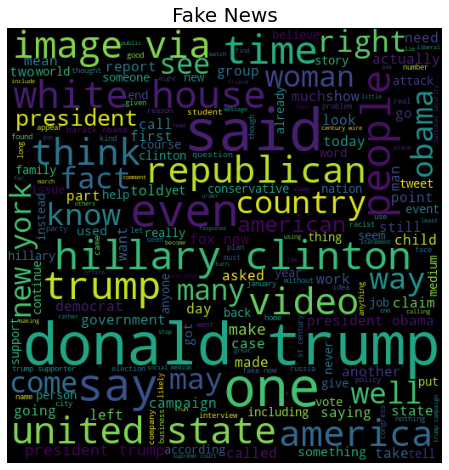

In [15]:
wordcloud(fake_news,'Fake News')

### True News WordCloud

We can detect the words `donald trump` , `hillary clinton`, `said`, `republican` and so on, which might be be associated with a true news. Actually the true news are not much different from the fake news.

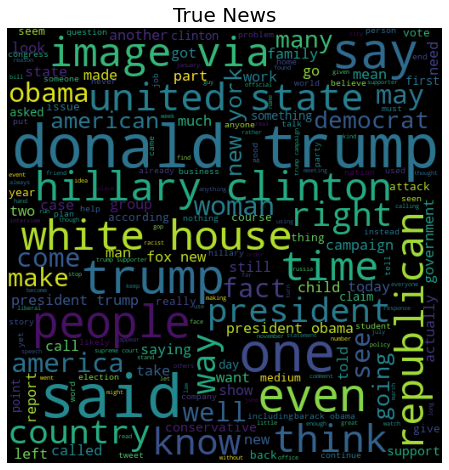

In [16]:
wordcloud(true_news,'True News')

## Showing top 10 unigrams and bigrams

In [17]:
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]

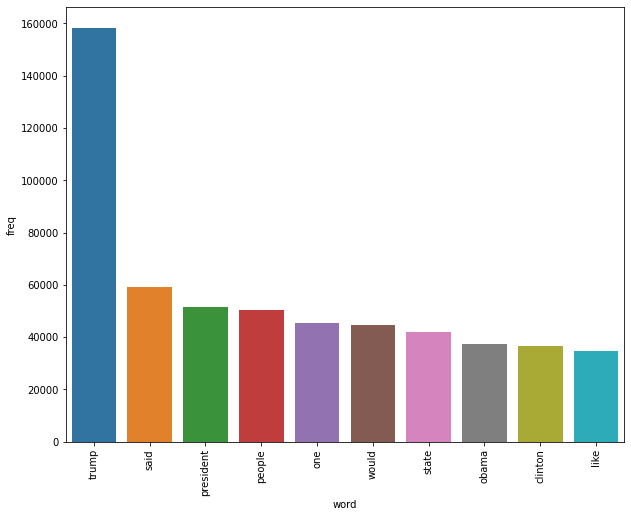

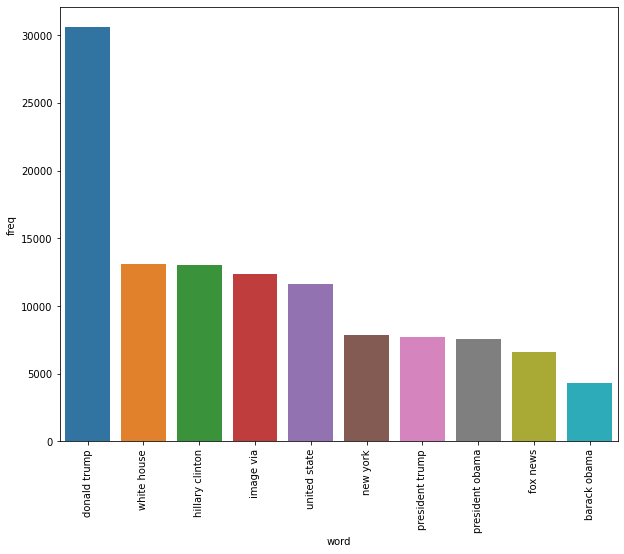

In [18]:
common_uni_df = pd.DataFrame(top_ngrams(data['cleansed'], 10, 1), columns=['word','freq'])
common_bi_df = pd.DataFrame(top_ngrams(data['cleansed'], 10, 2), columns=['word','freq'])

plt.figure(figsize=(10,8))
sns.barplot(x='word', y='freq', data=common_uni_df)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(x='word', y='freq', data=common_bi_df)
plt.xticks(rotation=90)
plt.show()

# 5. Preprocessing Data

## Extracting the feature and label

In [19]:
X = data['cleansed']
y = data['label']

## Tokenizing the Texts

Tokenizing the texts. Tokenizing will split the texts into the vectors of words so that the computer can process them.

In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X.values)
vocab_length = len(word_tokenizer.word_index) + 1

## Padding the Text

Padding the text so that each text has the same length.

In [21]:
longest_train = max(X.values, key=lambda text: len(word_tokenize(text)))
length_long_text = len(word_tokenize(longest_train))

# padding
padded_texts = pad_sequences(word_tokenizer.texts_to_sequences(X.values), length_long_text, padding='post')

## Creating the Embedding Word Matrix

We will create our own word matrix which return the vector of word (Vector Data Source: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt)

In [22]:
embeddings_dictionary = dict()
embedding_dim = 100


TXT_PATH = '../input/glove6b100dtxt/glove.6B.100d.txt'

# loading the vectors of words from the file
with open(TXT_PATH) as f:
    for line in f:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# create matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# 6. Training Models

We will create two models in this section: a convolution neural network model and a multi-channel convolution neural network model.

## Spliting the Data for Train and Validation

We will split the data at the ratio below:
- train_size: 80% of the data
- validaton_size: 20% of the data

In [23]:
X_train, X_val, y_train, y_val = train_test_split(padded_texts, y.values, test_size=0.2, random_state=1)

In [24]:
# a helper function for showing model history
def model_history(model_history):
    epochs = list(range(1, len(model_history.history['accuracy']) + 1))
    # accuracy    
    data_preproc = pd.DataFrame({
        'epochs': epochs, 
        'accuracy': model_history.history['accuracy'],
        'val_accuracy': model_history.history['val_accuracy']
    })
    plt.figure(figsize=(8,6))
    ax = sns.lineplot(x='epochs', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['epochs']))
    ax.set_title('model accuracy')
    plt.show()

    # loss    
    data_preproc = pd.DataFrame({
        'epochs': epochs, 
        'loss': model_history.history['loss'],
        'val_loss': model_history.history['val_loss']
    })
    plt.figure(figsize=(8,6))
    ax = sns.lineplot(x='epochs', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['epochs']))
    ax.set_title('model loss')
    plt.show()

## Creating the Convolutional Neural Network

We will create a normal CNN model (single input) with the definition of the next code.

In [25]:
def create_cnn_model(hp):    
    model = Sequential()

    model.add(Embedding(vocab_length, 100, weights=[embedding_matrix],
                                     input_length=length_long_text,trainable=False))
    model.add(Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=200,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5]),
                                activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units = hp.Int('dense_1',min_value=21,max_value=150,step=14), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
  
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Using Keras-Tuner(kt) to get the best hyperparameters.

In [26]:
tuner_cnn = kt.Hyperband(create_cnn_model,
                         objective='val_accuracy',
                         max_epochs=15,
                         factor=5,
                         directory='cnn_model',
                         project_name='NewsClassification',
                         overwrite=True)

2022-06-17 22:06:23.716178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 22:06:23.837633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 22:06:23.838365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 22:06:23.840540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
stop_early = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

tuner_cnn.search(X_train, y_train,
                 epochs=15,
                 validation_data=(X_val,y_val),
                 callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparams_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 06m 23s]
val_accuracy: 0.5232739448547363

Best val_accuracy So Far: 0.9320712685585022
Total elapsed time: 00h 46m 28s


Creating a model using the best hyperparameters.

In [28]:
model_cnn = tuner_cnn.hypermodel.build(best_hyperparams_cnn)
# showing the model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4825, 100)         16820900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4823, 189)         56889     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4823, 189)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2411, 189)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 455679)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 119)               54225920  
_________________________________________________________________
dropout_3 (Dropout)          (None, 119)              

In [29]:
# train
history_cnn = model_cnn.fit(X_train,
                            y_train,
                            epochs=20,
                            validation_data=(X_val,y_val),
                            callbacks=[stop_early])

Epoch 1/20
1123/1123 [==============================] - 36s 31ms/step - loss: 0.3716 - accuracy: 0.8305 - val_loss: 0.2211 - val_accuracy: 0.9075
Epoch 2/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.2008 - accuracy: 0.9211 - val_loss: 0.1959 - val_accuracy: 0.9233
Epoch 3/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.1375 - accuracy: 0.9479 - val_loss: 0.1836 - val_accuracy: 0.9254
Epoch 4/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.1032 - accuracy: 0.9632 - val_loss: 0.1895 - val_accuracy: 0.9281
Epoch 5/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.0776 - accuracy: 0.9726 - val_loss: 0.1970 - val_accuracy: 0.9286
Epoch 6/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.2295 - val_accuracy: 0.9290
Epoch 7/20
1123/1123 [==============================] - 35s 31ms/step - loss: 0.0496 - accuracy: 0.9827 - val_loss: 0.2345 -

Plotting the accuracy and loss history. **The validation accuracy is around 92% in the 2nd epoch.**

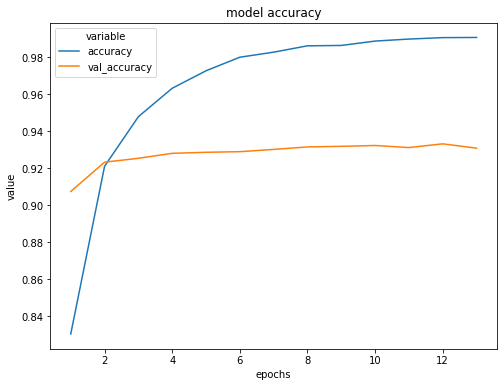

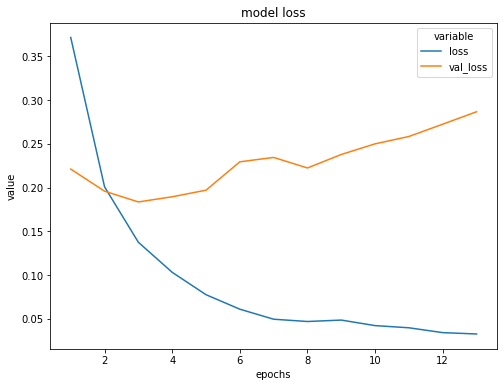

In [30]:
model_history(history_cnn)

## Creating the Multi-Channel Convolutional Neural Network

We will create a normal CNN model (double inputs) with the definition of the next code.

In [31]:
def create_multi_channel_cnn(hp):
    # input 1
    inputs1 = Input(shape=(length_long_text,))

    embedding1 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_text, trainable=False)(inputs1)     
    conv1 = Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding1) 
    drop1 = Dropout(0.3)(conv1) 
    pool1 = MaxPooling1D()(drop1) 
    flat1 = Flatten()(pool1)
    
    # input 2
    inputs2 = Input(shape=(length_long_text,)) 
    embedding2 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_text,trainable=False)(inputs2) 
    conv2 = Conv1D(filters=hp.Int('conv_2_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_2_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding2) 
    drop2 = Dropout(0.3)(conv2) 
    pool2 = MaxPooling1D()(drop2) 
    flat2 = Flatten()(pool2) 
    
    # merge 
    merged = concatenate([flat1, flat2]) 
    
    dense1 = Dense(units = hp.Int('dense_1',min_value=21,max_value=120,step=14),
                               activation='relu')(merged)
    drop3 = Dropout(0.5)(dense1)
    
    outputs = Dense(1, activation='sigmoid')(drop3) 
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Using Keras-Tuner(kt) to get the best hyperparameters.

In [32]:
tuner_mcnn = kt.Hyperband(create_multi_channel_cnn,
                          objective='val_accuracy',
                          max_epochs=15,
                          factor=5,
                          directory='mcnn_model',
                          project_name='NewsClassification',
                          overwrite=True)

In [33]:
stop_early = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

tuner_mcnn.search([X_train,X_train],y_train, epochs=15,
                  validation_data=([X_val,X_val], y_val),
                  callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparams_mcnn = tuner_mcnn.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 09m 23s]
val_accuracy: 0.9138084650039673

Best val_accuracy So Far: 0.9259465336799622
Total elapsed time: 00h 49m 27s


Creating a model using the best hyperparameters.

In [34]:
model_mcnn = tuner_mcnn.hypermodel.build(best_hyperparams_mcnn)
# showing the model summary
model_mcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4825)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4825)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4825, 100)    16820900    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 4825, 100)    16820900    input_4[0][0]                    
____________________________________________________________________________________________

In [35]:
history_mcnn = model_mcnn.fit([X_train,X_train], y_train,
                              epochs=20,
                              validation_data=([X_val,X_val], y_val),
                              callbacks=[stop_early])

Epoch 1/20
1123/1123 [==============================] - 22s 19ms/step - loss: 0.4070 - accuracy: 0.7986 - val_loss: 0.2381 - val_accuracy: 0.8999
Epoch 2/20
1123/1123 [==============================] - 22s 19ms/step - loss: 0.2267 - accuracy: 0.9070 - val_loss: 0.2162 - val_accuracy: 0.9192
Epoch 3/20
1123/1123 [==============================] - 21s 19ms/step - loss: 0.1686 - accuracy: 0.9326 - val_loss: 0.1896 - val_accuracy: 0.9213
Epoch 4/20
1123/1123 [==============================] - 21s 19ms/step - loss: 0.1354 - accuracy: 0.9472 - val_loss: 0.1864 - val_accuracy: 0.9241
Epoch 5/20
1123/1123 [==============================] - 21s 19ms/step - loss: 0.1106 - accuracy: 0.9562 - val_loss: 0.1847 - val_accuracy: 0.9285
Epoch 6/20
1123/1123 [==============================] - 21s 19ms/step - loss: 0.0935 - accuracy: 0.9641 - val_loss: 0.1884 - val_accuracy: 0.9283
Epoch 7/20
1123/1123 [==============================] - 21s 19ms/step - loss: 0.0827 - accuracy: 0.9689 - val_loss: 0.2081 -

Plotting the accuracy and loss history. **The validation accuracy is around 92% in the 3rd epoch.**

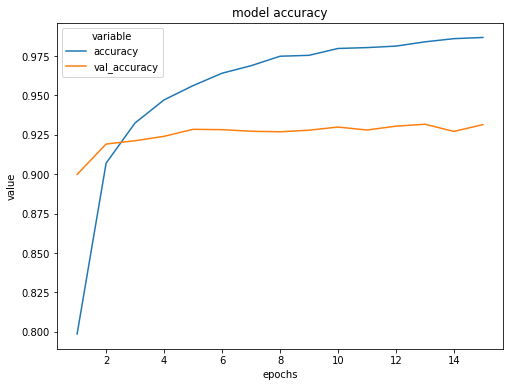

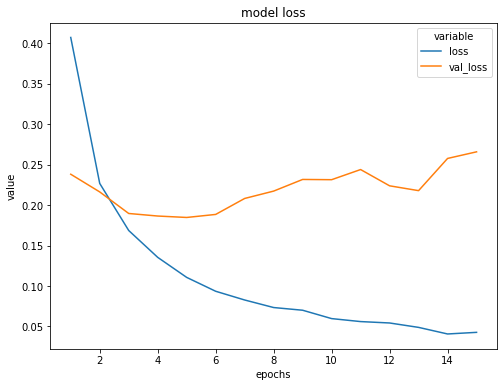

In [36]:
model_history(history_mcnn)

# Discussion

Both of the models have almost the same validation accuracy (around 91.6% and xx.x% for each) even though the number of inputs is different. They are good enough for practical use.

For a better model,
- more sofisticated data cleansing might be required to remove 'noisy' words and symbols
- more complex neural networks might have a better result